학습 목표
- 언어 모델이 발전해 온 과정을 개략적으로 파악한다.
- 기존 RNN 기법이 번역에서 보인 한계를 파악하고, 이를 개선한 Seq2seq를 이해한다.
- Seq2seq를 발전시킨 Attention에 대해 알아본다.

## 우리가 만드는 언어 모델

언어 모델(Language Model)이란, 주어진 단어들을 보고 다음 단어를 맞추는 모델입니다.  
더 자세하게는, 단어의 시퀀스를 보고 다음 단어에 확률을 할당 하는 모델이죠!

좀 더 수학적으로 표현하면,  
언어 모델은 n-1 개의 단어 시퀀스가 주어졌을 때, n 번째 단어로 무엇이 올지를 예측하는 확률 모델로 표현합니다.

### 통계적 언어 모델 (Statistical Language Model)

https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/ 참고

"등장한 적이 없는 단어나 문장에 대해 모델링을 할 수 없다" 는 통계적 언어 모델의 단점은 치명적이었다.

데이터가 아무리 많다고해도 세상 모든 단어를 포함할 수는 없었으니 말이다.

### 신경망 언어 모델 (Neural Network Language Model, NNLM)

https://wikidocs.net/45609 참고

희소문제(sparsity problem)이 존재한다.
- 희소 문제란, 모델이 충분한 데이터를 관측하지 못하면 언어를 정확히 모델링 할 수 없는 문제를 말한다. 
- 한 번도 관측하지 못한 데이터에 대해선 0에 확률을 부여한다는 것에서 문제가 발생한다.

원-핫 입력이 투사층을 거쳐가는 것은 해당 행을 읽어오는 것과 동일하다는 데에서 붙여진 이름은?
- 룩업 테이블 (lookup table)

출력 층에서 사용되는 활성함수 Softmax는 어떤 의미를 갖는가?
- 소프트맥스 함수를 거쳐 나온 0-1 사이 값은 해당 인덱스에 대한 확률을 의미한다.

하지만 예측에 정해진 개수의 단어만 참고한다는 분명한 한계가 있었습니다.  
예를 들어 번역문을 생성하려면 문장이 짧을 수도, 길 수도 있으니, n개의 단어를 참고하기보다는 "몇 개 단어가 들어와도 문장 단위로 처리한다!"는 종류의 모델링이 필요하게 되었죠. 

그렇게 고안된 것이 바로 여러분들이 잘 알고 계신 순환 신경망(Recurrent Neural Network, 이하 RNN)을 활용한 언어 모델 입니다.

## Sequence to Sequence 문제

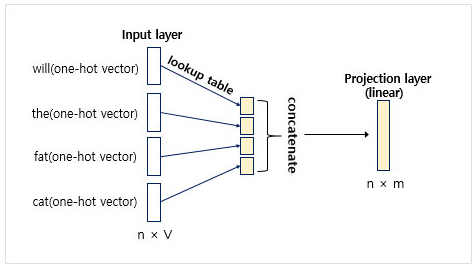

In [1]:
from IPython.display import Image
Image(filename='capture/10_nnlm_architecture.png') 

다시 한번 설명하면, 
- 여러 개의 단어(Embedding)를 합쳐(Concatenate) 고정된 크기의 Weight를 Linear로 처리하는 방식은 유연성에 한계가 있었습니다. 
- 단어의 개수에 무관하게 처리할 수 있는 네트워크가 필요했고, 그것은 곧 RNN의 고안으로 이어졌습니다. 
- RNN은 고정된 크기의 Weight가 선언되는 것은 동일하지만 입력을 순차적으로 "적립"하는 방식을 채택함으로써 유동적인 크기의 입력을 처리할 수 있었습니다.

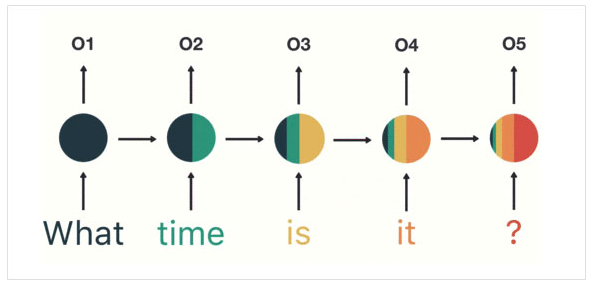

In [2]:
from IPython.display import Image
Image(filename='capture/10_rnn_illustration.png') 

대표적으로 RNN에는 두 가지 문제점이 꼽히곤 합니다.
- 하나의 Weight에 입력을 적립하다 보니 입력이 길어질수록 이전 입력에 대한 정보가 소실되는 기울기 소실(Vanishing Gradient) 문제가 있습니다. 
  - 위 그림에서 What 에 해당하는 남색이 마지막 단계인 ? 에서는 거의 희석된 모습을 볼 수 있다.
- 단어 단위로 입력과 출력을 순환하는 RNN 구조는 문장 생성엔 적합할지언정 번역에 사용하기는 어렵다는 문제가 있습니다.
  - 각 언어별로 어순이 다르기 때문이다.
  
그래서

번역에 있어서는 문장을 다 읽고 번역하는, 즉 문장 전체를 보고 나서 생성하는 구조가 필요했습니다. 

이에 2014년, 구글이 Sequence to Sequence(Seq2Seq) 구조를 제안합니다.  
논문: https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf  
https://reniew.github.io/35/ 참고  
https://wikidocs.net/24996 참고

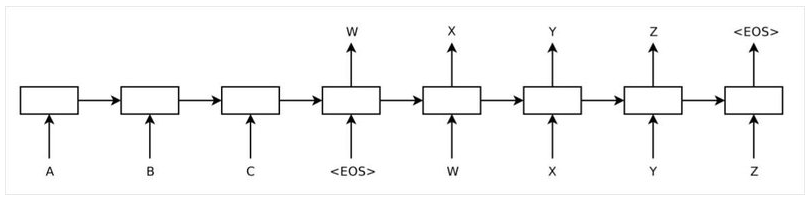

In [3]:
from IPython.display import Image
Image(filename='capture/10_seq2seq_learning_with_nn.png') 

seq2seq의 저자들은 단순한 RNN 대신 LSTM을 사용하고자 하였습니다. 그 이유는?
- 단순한 RNN은 긴 입력에 대한 정보를 학습시키기 어렵기 때문이다.

논문의 2. The Model의 마지막 문단은 입력과 출력의 "establish communication"에 대해 설명하고 있습니다. 이에 대해 설명하면?
- 입력 abc와 출력 def에 대해 a->d, b->e, c->f의 관계를 가진다면 입력을 cba로 뒤집어도 관련 있는 단어 사이의 평균 거리는 같게 유지된다.
- 그런데 a와 d의 거리는 매우 가까워지고, b와 e의 거리는 상당히 가까워진다. 
- 이런 변형은 SGD가 입출력 간의 구조적 관계를 파악하는 것을 용이하게 하고 LSTM에 대해 성능을 Boost하는 효과가 있다. 
- 특히 논문의 3.3 Reversing the Source Sentences 두 번째 문단을 보면, 단어 사이의 평균 거리는 유지되면서 문장의 앞 부분 단어의 거리가 줄어들기 때문에 학습 효과가 높아지는 것으로 추측하고 있다.

Encoder은 입력 문장의 모든 단어들을 순차적으로 입력받고 모든 단어를 압축한 단 하나의 "컨텍스트 벡터" 를 만든다.

문장의 시작과 끝에 붙는 특수한 토큰들이 있따. 그 토큰들이 없다면?
- 시작 토큰이 없다면?
  - Decoder의 첫 입력으로 전달할 단어가 없어져 번역을 진행할 수 없다. 만일 랜덤한 단어를 입력으로 넣는 경우, 번역의 성능에 문제가 생긴다.
- 끝 토큰이 없다면?
  - 문장의 끝을 알릴 수 없어 단어를 무한정 생성하게 된다.
  
문맥을 더 잘 반영하는 벡터를 생성하는 메커니즘은?
- 어텐션 메커니즘

## Sequence to Sequence 구현

TensorFlow 로 구현해보자.

일단은 데이터를 직접 다루기보다는 차원 수를 확인하는 실습을 해보겠습니다.  
RNN 계통의 레이어들은 입력값과 반환값이 설정에 따라 각양각색입니다.  
이번 구현에서는 입력으로 Embedding된 단어만 전달하고 (Hidden State는 전달하지 않습니다), 출력은 Encoder와 Decoder 별로 상이하므로 각각 설명을 첨부하겠습니다.

### LSTM Encoder

In [4]:
import tensorflow as tf

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(enc_units) # return_sequences 매개변수를 기본값 False로 전달

  def call(self, x):
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    output = self.lstm(x)
    print("LSTM Layer의 Output Shape:", output.shape)

    return output

print("슝~")

슝~


TensorFlow 속 LSTM 모듈의 기본 반환 값은 최종 State 값이므로 return_sequences 나 return_state 값은 따로 조정하지 않습니다 (기본: False).

즉, 우리가 정의해 준 Encoder 클래스의 반환 값이 곧 컨텍스트 벡터(Context Vector)가 되는 것이다.

In [5]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [6]:
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input)    # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State값

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
LSTM Layer의 Output Shape: (1, 512)


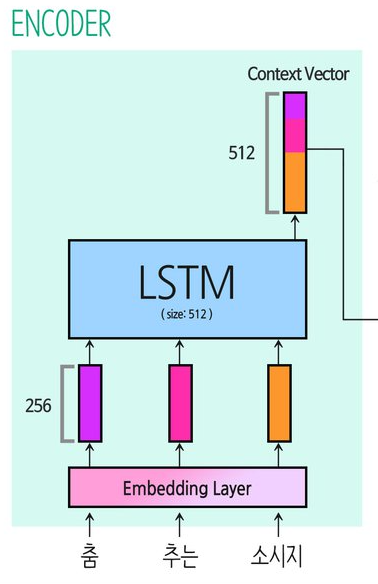

In [7]:
from IPython.display import Image
Image(filename='capture/10_seq2seq_encoder.png') 

### LSTM Decoder

In [8]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 유의!

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(dec_units,
                                     return_sequences=True) # return_sequences 매개변수를 True로 설정
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.softmax = tf.keras.layers.Softmax(axis=-1)

  def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                          repeats=x.shape[1], axis=1)
    x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
    print("Context Vector가 더해진 Shape:", x.shape)

    x = self.lstm(x)
    print("LSTM Layer의 Output Shape:", x.shape)

    output = self.fc(x)
    print("Decoder 최종 Output Shape:", output.shape)

    return self.softmax(output)

print("슝~")

슝~


Decoder는 Encoder와 구조적으로 유사하지만 결과물을 생성해야 하므로 Fully Connected 레이어가 추가되었고, 출력값을 확률로 변환해 주는 Softmax 함수도 추가되었습니다.

그리고 Decoder가 매 스텝 생성하는 출력은 우리가 원하는 번역 결과에 해당하므로 LSTM 레이어의 return_sequences 변수를 True로 설정하여 State 값이 아닌 Sequence 값을 출력으로 받습니다.

In [9]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [10]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
Context Vector가 더해진 Shape: (1, 3, 768)
LSTM Layer의 Output Shape: (1, 3, 512)
Decoder 최종 Output Shape: (1, 3, 30000)


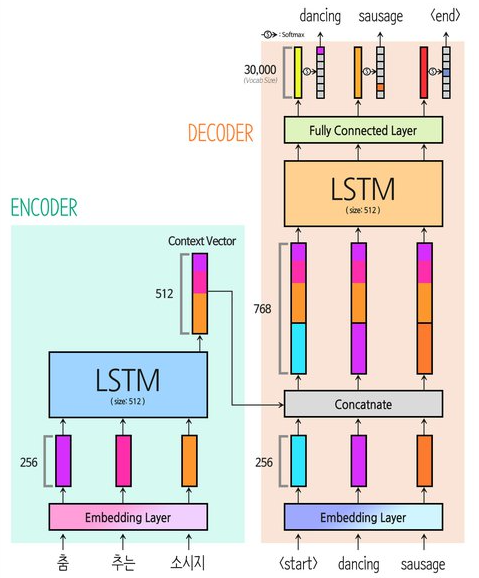

In [11]:
from IPython.display import Image
Image(filename='capture/10_seq2seq_architecture.png') 

## Attention! (1) Bahdanau Attention

Seq2Seq 역시 여느 기법처럼 한계점이 존재했으며 이를 발전시키려는 시도가 아주 많았습니다. 

가장 대표적인 방법이 바로 Attention 메커니즘입니다.

### Bahdanau Attention

Bahdanau는 Seq2Seq의 컨텍스트 벡터가 고정된 길이로 정보를 압축하는 것이 손실을 야기한다고 주장하였다.

즉 짧은 문장에 대해서는 괜찮을지 모르겠으나, 문장이 길어질수록 성능이 저하된다는 것이다.

이에 그는 Encoder의 최종 State 값만을 사용하는 기존의 방식이 아닌, 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축하는 Attention 메커니즘을 제안합니다.  
https://arxiv.org/pdf/1409.0473.pdf 참고  
https://lovit.github.io/machine%20learning/2019/03/17/attention_in_nlp/ 참고

Sequence Labeling과 Sequence to Sequence의 예시를 하나씩 적고, 두 Task의 차이점에 대해 간단히 설명해보자.
- Sequence Labeling은 Xi 와 Yi 간의 관계를 구하는 문제지만
- Sequence to Sequence 는 X1:n 과 동일한 의미를 가지는 Y1:m 을 만다는 문제이다.
- 예시
  - Sequence Labeling: 품사 태깅
  - Sequence to Sequence: 번역

### seq2seq과 attn-seq2seq, 뭐가 다른가?

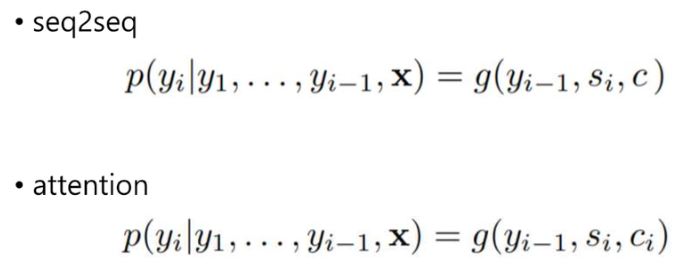

In [12]:
from IPython.display import Image
Image(filename='capture/10_seq2seq_vs_attention.png') 

유일한 차이는 attention이 있는 경우엔 바로 context vector cc에 첨자 ii가 붙어있다는 점입니다.

"인코더가 X를 해석한 context c_i 는 디코더의 포지션 i에 따라 다르게 표현(represent)되어야 한다."

seq2seq의 인코더가 해석한 context는 디코더의 포지션 ii에 무관하게 항상 일정했습니다. 그러나 attention이 가미되면 달라집니다.

'나는 밥을 먹었다'라는 한글 문장을 'I ate lunch'로 번역한다고 생각해 봅시다. 

영어 문장의 첫 번째(i=0) 단어 'I'를 만들어야 할 때 인코더가 한글 문장을 해석한 컨텍스트 벡터에서는 '나는'이 강조되어야 하고, 영어 문장의 세 번째(i=2) 단어 'lunch'를 만들어야 할 때 인코더의 컨텍스트 벡터에서는 '밥을'이 강조되어야 한다는 것입니다. 

디코더가 현재 시점 ii에서 보기에 인코더의 어느 부분 jj가 중요한가? 이 가중치가 바로 attention인 것입니다.

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W_decoder = tf.keras.layers.Dense(units)
    self.W_encoder = tf.keras.layers.Dense(units)
    self.W_combine = tf.keras.layers.Dense(1)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    H_encoder = self.W_encoder(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", H_encoder.shape)

    print("\n[ H_decoder ] Shape:", H_decoder.shape)
    H_decoder = tf.expand_dims(H_decoder, 1)
    H_decoder = self.W_decoder(H_decoder)
    
    print("[ W_decoder X H_decoder ] Shape:", H_decoder.shape)

    score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
    print("[ Score_alignment ] Shape:", score.shape)
    
    attention_weights = tf.nn.softmax(score, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    context_vector = attention_weights * H_decoder
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

W_size = 100

print("Hidden State를 {0}차원으로 Mapping\n".format(W_size))

attention = BahdanauAttention(W_size)

enc_state = tf.random.uniform((1, 10, 512))
dec_state = tf.random.uniform((1, 512))

_ = attention(enc_state, dec_state)

Hidden State를 100차원으로 Mapping

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 100)

[ H_decoder ] Shape: (1, 512)
[ W_decoder X H_decoder ] Shape: (1, 1, 100)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[0.08302238]
  [0.0837785 ]
  [0.10632747]
  [0.11586758]
  [0.07529979]
  [0.08928058]
  [0.13890429]
  [0.12280082]
  [0.1126543 ]
  [0.07206431]]]


## Attention! (2) Luong Attention

### Luong Attention

Luong의 Attention은 Bahdanau의 방식을 약간 발전시킨 형태입니다. 

Decoder의 현재 Hidden State를 구하기 위해 한 스텝 이전의 Hidden State를 활용하는 것은 연산적으로 비효율적입니다.  
이는 RNN의 연산 형태 때문인데, 자세한 내용은 아래 웹페이지에서 확인하시죠! 수식적인 부분은 완벽하게 이해하지 않아도 좋으니, Luong의 아이디어에 중점을 맞추도록 합니다.

https://hcnoh.github.io/2019-01-01-luong-attention 참고

4가지 score function
- Content-Based
  - Dot, General, Concat
- Location-Based

가장 합리적인 성능을 보이는 함수는 General 이다.

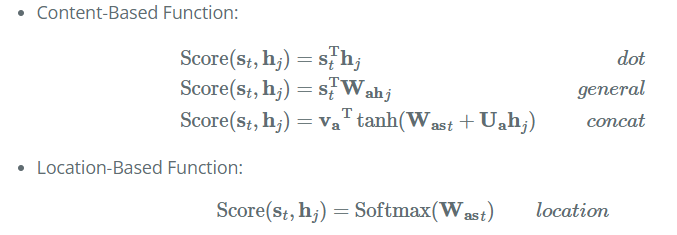

In [15]:
from IPython.display import Image
Image(filename='capture/10_luong_attention_score_function.png') 

In [14]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W_combine = tf.keras.layers.Dense(units)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    WH = self.W_combine(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", WH.shape)

    H_decoder = tf.expand_dims(H_decoder, 1)
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
    print("[ Score_alignment ] Shape:", alignment.shape)

    attention_weights = tf.nn.softmax(alignment, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    attention_weights = tf.squeeze(attention_weights, axis=-1)
    context_vector = tf.matmul(attention_weights, H_encoder)

    return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 512)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[7.6465979e-02]
  [1.2892181e-04]
  [4.0444904e-03]
  [1.4986010e-01]
  [2.7849434e-03]
  [1.8238147e-01]
  [8.7353408e-05]
  [5.7405536e-03]
  [1.1909641e-03]
  [5.7731521e-01]]]


Bahdanau의 Score 함수와는 다르게 하나의 Weight만을 사용하는 것이 특징입니다. 

어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능합니다.

## 트랜스포머로 가기 전 징검다리?

Seq2seq와 Attention이 폭풍처럼 휩쓸고 난 후, 잠잠해진 NLP 계를 다시 깨운 것은 2016년 구글의 신경망 번역 시스템 이었습니다.  
GNMT (Google Neural Machine Translation)

놀라운 구조를 제안한 것은 아니나 무려 8개 층을 쌓은 Encoder-Decoder 구조와 Residual Connection은 제법 멋졌죠.  
https://norman3.github.io/papers/docs/google_neural_machine_translation.html 참고

GNMT 는
- Bahdanau Attention 방식을 채택했다.
- Residual Connection을 사용했을 때의 이점이 몇 가지 있다.
  - 정확도가 올라간다.
  - 학습 속도가 빨라진다.
  - Gradient Exploding / Vanishing 문제를 해결한다.
- Copy Model 을 사용하는데 Copy Model 이란?
  - 그냥 모르는 단어는 번역 후에도 그냥 그대로 사용하는 것
  - 한 번도 본 적 없는 단어에 대해서 `<UNK>` 토큰 처리를 하지 않고 단어를 그대로 복사하여 적당한 위치에 배치하는 모델이다.

GNMT(Google Neural Machine Translation)는 어쩌면 복선이었을 수도 있는데,  
왜냐하면 그 후에 등장한 것이 NLP의 꽃, 트랜스포머(Transformer) 이기 때문이죠! 

앞서 언급한 레이어를 쌓는 구조나 Residual Connection이 트랜스포머와 굉장히 유사하기에 그렇게 느껴지기도 합니다.

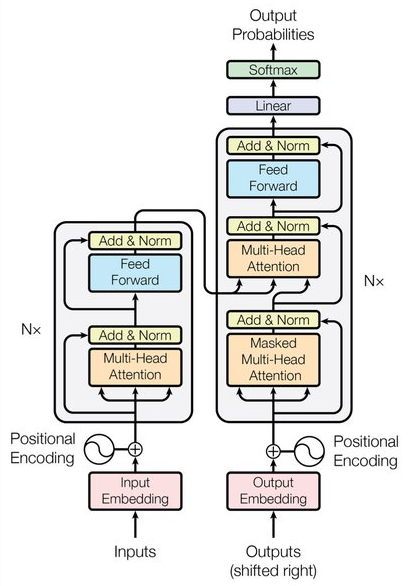

In [1]:
from IPython.display import Image
Image(filename='capture/10_transformer_architecture.png') 

트랜스포머 모델은 Multi-Head Attention이라는 개념을 도입해 폭넓은 문맥을 파악하게 하고,  
기존의 RNN 구조를 완전히 탈피하여 연산 속도 측면에서도 혁신적인 발전이 일어났습니다! 

지금까지도 트랜스포머를 기반으로 한 모델들이 각 분야에서 최고의 성능을 내고 있으니, 그 파급력을 알 만하죠?